# Модель курса доллара к рублю на основе цены нефти

В статье ["Формула рубля"](https://carnegie.ru/commentary/73225) Еуджениу Кирэу и Андрей Мовчан привели модель курса доллара к рублю, которая использует только один параметр - цену нефти. Я попробую здесь воспроизвести расчёты коэффициентов модели.

## Данные
Используются данные о цене нефти, инфляции в США и РФ, курсе доллара США к рублю. В общем случае наборы данных защищены авторским правом (copyright), и их использование требует получения разрешения. Я использую здесь только те данные, источники которых не являются коммерческими организациями. Источники требуют только цитирования.


### Цена нефти
Данные о дневных ценах нефти марки Brent загружаю с сайта FRED: https://fred.stlouisfed.org/series/DCOILBRENTEU. Цены спотовые, не фьючерс. Исходным источником данных является U.S. Energy Information Administration (Управление Энергетической Информации США).

Для моделирования можно использовать цены марки Urals, но их сложнее получить. На сайте самого Росстата данные присутствуют не полностью. Искать нужно по фразе "О состоянии рынка нефти". Я не нашёл данных о ценах Urals ранее 2004.

### Инфляция в США
Ежемесячные данные об инфляции в США загружаю с сайта FRED: https://fred.stlouisfed.org/series/CPIAUCNS. Исходным источником данных является U.S. Bureau of Labor Statistics (Бюро Трудовой Статистики Министерства Труда США).
График выпуска релизов BLS об инфляции: https://www.bls.gov/schedule/news_release/cpi.htm.

### Инфляция в РФ
Ежемесячные данные об инфляции РФ загружаю напрямую с сайта Росстата: https://rosstat.gov.ru/price.
График выпуска релизов Росстата: https://gks.ru/compendium/document/50798.

### Курс доллара США к рублю
Данные о курсе доллара к рублю загружаю напрямую с сайта ЦБ РФ: http://www.cbr.ru/development/SXML/.

Данные об инфляции выходят раз в месяц. Новые данные о цене нефти и курсе валюты доступны ежедневно. Я привожу все данные к периоду в один месяц с датой каждого значения, соответствующей последнему дню в месяце. Т.е. цена нефти в декабре указана на дату 31 декабря со значением цены, равным последнему известному фактическому значению цены в этом месяце. С курсом доллара точно так же. Данные о текущем индексе инфляции за месяц аналогично указаны на дату последнего дня месяца (а не на дату начала следующего).

Графики, которые я строю в дальнейшем, отображают наборы используемых сэмплов. Экстремальные значения цены нефти и курса доллара на них не соответствуют фактическим экстремальным значениям, т.к. экстремумы не совпадают с точками сэмплирования.

### Загрузка данных

Стандартная преамбула: использую bs4, requests, pandas, numpy, scipy и matplotlib.

In [1]:
%matplotlib inline
from bs4 import BeautifulSoup
from urllib.parse import urljoin
import requests, re
import pandas as pd
import pandas_datareader.data as web
import datetime as dt
import urllib.request
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

В качестве базового года я беру 2004, т.к. изначально я использовал цену нефти марки Urals, а данных по её ценам ранее этого года в у меня не было:

In [2]:
BASE_YEAR = 2004
base = dt.datetime(BASE_YEAR, 1, 1)

Загружаю дневные цены Brent, очищаю, ресемплирую:

In [3]:
oil = web.DataReader('DCOILBRENTEU', 'fred', base)

def cleanse_df(df):
    df.index.names = ['Date']
    df.columns = ['Value']
    num_df = (df.drop(df.columns, axis=1).join(df[df.columns].apply(pd.to_numeric, errors='coerce')))
    num_df.dropna(inplace=True)
    return num_df

oil = cleanse_df(oil)
oil = oil.resample('M').last()

Загружаю данные об инфляции в США, очищаю, ресемплирую. В загружаемых данных значение индекса инфляции за месяц указано первым днём следующего месяца. Поэтому при загрузке указываю дату на один месяц ранее базовой даты. Приведение индекса к базовому году происходит делением всех значений на первое значение. Далее первое значение отбрасываю:

In [4]:
nbase = dt.datetime(BASE_YEAR - 1, 12, 1)
df = web.DataReader('CPIAUCNS', 'fred', nbase)
df = cleanse_df(df)
df = df.resample('M').last()
df = df / df.iloc[0]
df = df[base:]
cpi_us = df

Загружаю данные об инфляции в РФ, очищаю, ресемплирую. Pandаs умеет работать с форматом Excel:

In [5]:
url = 'https://rosstat.gov.ru/price'
page = requests.get(url)
soup = BeautifulSoup(page.content, 'html.parser')
a = soup.find('a', href=re.compile(u'Индексы потребительских цен.htm'))
url = urljoin(url, a['href'])
page = requests.get(url)
soup = BeautifulSoup(page.content, 'html.parser')
a = soup.find('a')
url = a['href']

df = pd.read_excel(url, skiprows=[0, 1, 2, 4], skipfooter=3)
first_year = df.columns.values[1]
first_month = df[first_year].first_valid_index() + 1
start = dt.datetime(first_year, first_month, 1)
last_year = df.columns.values[-1]
last_month = df[last_year].last_valid_index() + 1
end = dt.datetime(last_year, last_month, 1)
df = pd.Series(df.values.ravel('F'))
df = df.iloc[12:].to_frame()
df = cleanse_df(df)
df.index = pd.date_range(start=start, end=end, freq='MS')
df = df.resample('M').last()
df = df[base:]
cpi_ru = df

Индекс на сайте Росстата представлен в виде значений к концу предыдущего месяца. Привожу полученный набор значений к индексу базового года:

In [6]:
cpi_ru.iloc[0]['Value'] /= 100.0
for i in range(1, len(cpi_ru)):
    cur = cpi_ru.iloc[i]['Value']
    prev = cpi_ru.iloc[i - 1]['Value']
    cpi_ru.iloc[i]['Value'] = cur * prev / 100.0

Загружаю курс доллара к рублю. С форматом XML pandas работать не умееет, делаю простой быстрый парсинг:

In [7]:
ts_start = cpi_ru.index[0]
ts_end = dt.datetime.now()
start = '{:02d}/{:02d}/{}'.format(1, ts_start.month, ts_start.year)
end = '{:02d}/{:02d}/{}'.format(ts_end.day, ts_end.month, ts_end.year)
url = 'http://www.cbr.ru/scripts/XML_dynamic.asp?date_req1={}&date_req2={}&VAL_NM_RQ=R01235'.format(start, end)
xml_data = urllib.request.urlopen(url).read()

xml_str = str(xml_data).split('Date="')[1:]
date = [i[0:0+len('dd.mm.yyyy')] for i in xml_str]
value = [i[51:51+len('xx.xxxx')] for i in xml_str]
df = pd.DataFrame(data=[date, value]).T
df.columns = ['Date', 'Value']
df.set_index('Date', inplace=True)
df.index = pd.to_datetime(df.index, format='%d.%m.%Y')
df['Value'] = [x.replace(',', '.') for x in df['Value']]
df['Value'] = df['Value'].astype(float)
df = df.resample('M').last()
usd_rub = df

Данные об инфляции в США и РФ выходят в разные дни месяца, поэтому в общем случае наборы данных будут не одинаковы по длине. При этом мне нужно будет отбросить последнее значение у одного или нескольких наборов. Данные о курсе доллара и цены нефти в общем случае содержат невалидное последнее значение. Вывожу даты последних значений, они будут отличаться:

In [8]:
print(oil.index[-1], cpi_us.index[-1], cpi_ru.index[-1], usd_rub.index[-1], sep='\n')

2019-11-30 00:00:00
2019-10-31 00:00:00
2019-10-31 00:00:00
2019-11-30 00:00:00


Убираю ненужные значения, проверяю:

In [9]:
cpi_us = cpi_us[cpi_us.index.isin(cpi_ru.index)].dropna()
cpi_ru = cpi_ru[cpi_ru.index.isin(cpi_us.index)].dropna()
oil = oil[oil.index.isin(cpi_ru.index)].dropna()
usd_rub = usd_rub[usd_rub.index.isin(cpi_ru.index)].dropna()
print(oil.index[-1], cpi_us.index[-1], cpi_ru.index[-1], usd_rub.index[-1], sep='\n')

2019-10-31 00:00:00
2019-10-31 00:00:00
2019-10-31 00:00:00
2019-10-31 00:00:00


### Проверка данных

Проверяю, что загруженные и обработанные наборы данных корректны.

Вывожу первое и последнее значения цен нефти Brent: на конец января 2004 и на конец октября 2019. Проверяю на сайте [EIA](https://www.eia.gov/dnav/pet/hist/RBRTED.htm). Совпадает.

In [10]:
print(oil.iloc[0], oil.iloc[-1], sep='\n')

Value    29.53
Name: 2004-01-31 00:00:00, dtype: float64
Value    59.3
Name: 2019-10-31 00:00:00, dtype: float64


Вывожу график используемых значений цены нефти Brent:

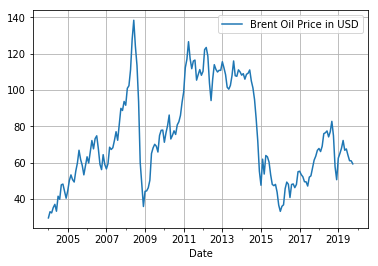

In [11]:
oil.plot(y='Value', label='Brent Oil Price in USD', grid=True);

Вывожу первое и последнее значения индекса инфляции США. Проверяю на одном из "инфляционных калькуляторов" в интернете. Инфляция за январь 2004 составила 0,4883%. Информации за 2019 в "инфляционном калькуляторе" пока нет, ограничиваюсь для проверки 2018 годом. За период с января 2004 по декабрь 2018 (оба месяца включительно) инфляция составила 36,3174%. Совпадает.

In [12]:
print(cpi_us.iloc[0], cpi_us[:'20190101'].iloc[-1], sep='\n')

Value    1.004883
Name: 2004-01-31 00:00:00, dtype: float64
Value    1.363174
Name: 2018-12-31 00:00:00, dtype: float64


Вывожу график индекса потребительских цен США. Заметна существенная дефляция в 2008:

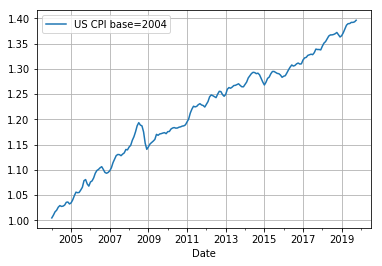

In [13]:
cpi_us.plot(y='Value', label='US CPI base=' + str(BASE_YEAR), grid=True);

Вывожу первое и последнее значения индекса инфляции РФ. Проверяю на одном из "инфляционных калькуляторов" в интернете. Инфляция за январь 2004 составила 1,75%. За период с января 2004 по декабрь 2019 (оба месяца включительно) инфляция составила 253,6669%. Совпадает.

In [14]:
print(cpi_ru.iloc[0], cpi_ru.iloc[-1], sep='\n')

Value    1.0175
Name: 2004-01-31 00:00:00, dtype: float64
Value    3.536669
Name: 2019-10-31 00:00:00, dtype: float64


Вывожу график индекса потребительских цен РФ. Заметно существенное ускорение инфляции в 2014-2015:

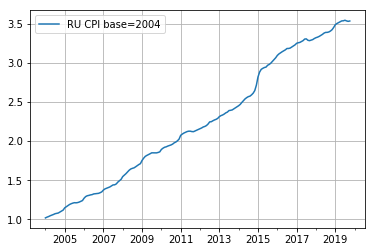

In [15]:
cpi_ru.plot(y='Value', label='RU CPI base=' + str(BASE_YEAR), grid=True);

Вывожу первое и последнее значения курса доллара к рублю. Проверяю на [сайте](http://www.cbr.ru/currency_base/daily/) ЦБ РФ. Совпадает.

In [16]:
print(usd_rub.iloc[0], usd_rub.iloc[-1], sep='\n')

Value    28.4937
Name: 2004-01-31 00:00:00, dtype: float64
Value    63.8734
Name: 2019-10-31 00:00:00, dtype: float64


Вывожу график используемых значений курса доллара США к рублю:

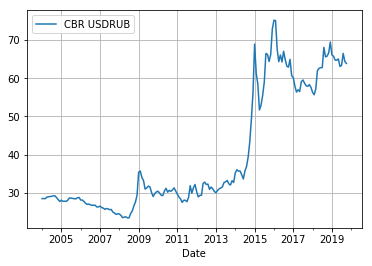

In [17]:
usd_rub.plot(y='Value', label='CBR USDRUB', grid=True);

Данные готовы. Перед тем как перейти к модели, построю ещё несколько графиков.

График цены нефти Brent в номинальных рублях:

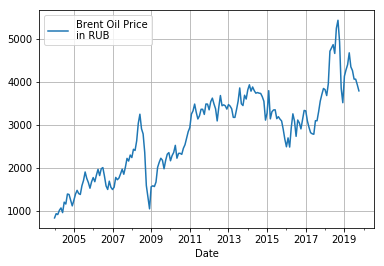

In [18]:
(oil * usd_rub).plot(y='Value', label='Brent Oil Price\nin RUB', grid=True);

График цены нефти Brent в рублях с поправкой на инфляцию в РФ (в рублях базового года):

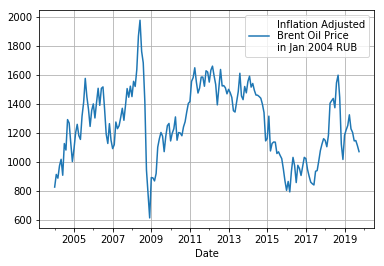

In [19]:
label = 'Inflation Adjusted\nBrent Oil Price\nin Jan %d RUB' % BASE_YEAR
(oil * usd_rub / cpi_ru).plot(y='Value', label=label, grid=True);

График цены нефти Brent в долларах с поправкой на инфляцию в США (в долларах базового года):

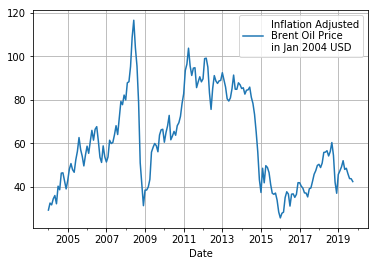

In [20]:
label = 'Inflation Adjusted\nBrent Oil Price\nin Jan %d USD' % BASE_YEAR
(oil / cpi_us).plot(y='Value', label=label, grid=True);

## Модель

Независимой (independent) переменной $X$ выступает цена нефти, скорректированная на инфляцию в США: 
\begin{align}
X_i = Oil_i / CPIUS_i\\
\end{align}
Зависимой (dependent) переменной $Y$ выступает курс доллара к рублю, скорректированный на инфляцию в РФ и инфляцию в США:
\begin{align}
Y_i = USDRUB_i / CPIRU_i * CPIUS_i\\
\end{align}

Строю диаграмму рассеяния (scatterplot):

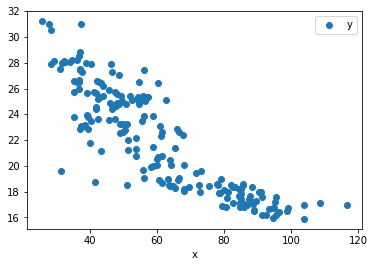

In [21]:
reg = pd.DataFrame()
reg['x'] = (oil / cpi_us)['Value']
reg['y'] = usd_rub['Value'] / cpi_ru['Value'] * cpi_us['Value']
reg.plot(x='x', y='y', style='o');

Используется log-log модель, т.е. соотношение между переменными рассматривается в виде формулы:
\begin{align}
\log Y_i = \alpha+\beta\log X_i\\
\end{align}
Коэффициенты $\alpha$ и $\beta$ вычисляются при помощи линейной регрессии. Предварительно значения обеих переменных подвергаются логарифмической трансформации (берётся натуральный логарифм каждого значения). Диаграмма приобретает следующий вид:

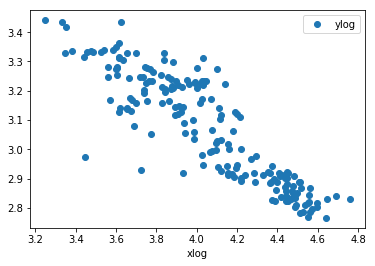

In [22]:
reg['xlog'] = reg['x'].apply(np.log)
reg['ylog'] = reg['y'].apply(np.log)
reg.plot(x='xlog', y='ylog', style='o');

Строю линейную регрессию по этим значениям, вывожу полученные коэффициенты $\alpha$ и $\beta$, коэффициент детерминации $R^2$, отображаю постороенную прямую на диаграмме:

alpha = 4.972484 beta = -0.469348 r_squared = 0.787554


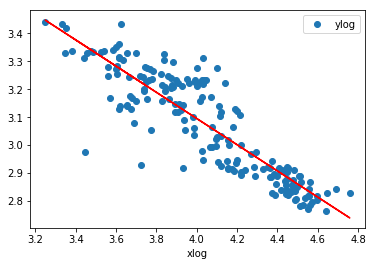

In [23]:
slope, intercept, r_value, p_value, std_err = stats.linregress(reg.xlog, reg.ylog)
beta, alpha, r_squared = slope, intercept, r_value ** 2
print('alpha = %f beta = %f r_squared = %f' % (alpha, beta, r_squared))
reg.plot(x='xlog', y='ylog', style='o')
plt.plot(reg.xlog, alpha + beta * reg.xlog, 'r');

Для перехода от модельной записи формулы, использовавшейся для построения регресии, к итоговому варианту, выполняю обратное преобразование - применяю экспоненциальную функцию к правой и левой части:
\begin{align}
e^{\log Y_i} = e^{\alpha+\beta\log X_i}\\
\end{align}
\begin{align}
Y_i = e^{\alpha+\beta\log X_i}\\
\end{align}

Строю полученный ряд значений на исходной диаграмме:

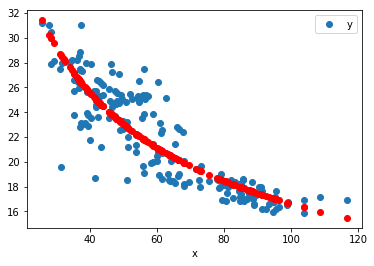

In [24]:
reg['model_log'] = alpha + beta * reg['xlog']
reg['usd_rub_estimate'] = reg['model_log'].apply(np.exp)
reg.plot(x='x', y='y', style='o')
plt.plot(reg.x, reg.usd_rub_estimate, 'ro');

Для получения модельных значений курса в номинальном выражений убираю поправку на инфляцию:

In [25]:
reg['usd_rub'] = usd_rub
reg['usd_rub_model'] = reg['usd_rub_estimate'] * cpi_ru['Value'] / cpi_us['Value']

Строю  на одном графике модельные и фактические значения курса доллара к рублю:

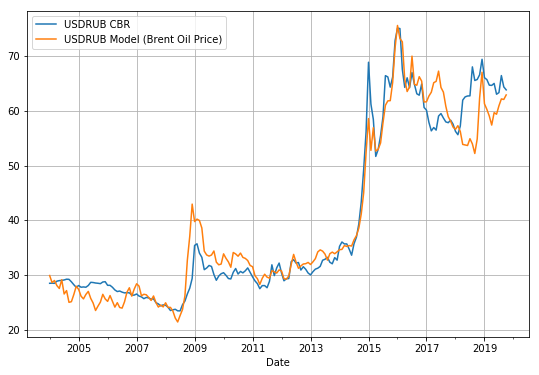

In [26]:
[width, height] = plt.rcParams['figure.figsize']
scale = 1.5
plt.rcParams['figure.figsize'] = [width * scale, height * scale]
plt.figure()
ax = reg['usd_rub'].plot.line(grid=True, label='USDRUB CBR')
ax = reg['usd_rub_model'].plot.line(grid=True, label='USDRUB Model (Brent Oil Price)')
ax.legend(['USDRUB CBR', 'USDRUB Model (Brent Oil Price)']);
plt.rcParams['figure.figsize'] = [width, height]

## Формула
Чтобы посчитать модельный курс доллара к рублю в каждый момент времени нужно знать:
- цену нефти Brent,
- текущий индекс инфляции в США относительно базового года,
- текущий индекс инфляции в РФ относительно базового года,
- рассчитанные коэффиценты $\alpha$ и $\beta$.

Формула имеет вид:
\begin{align}
USDRUB_i = \frac{CPIRU_i}{CPIUS_i} e^{\alpha+\beta\log\frac{Oil_i}{CPIUS_i}}\\
\end{align}

На 31 октября 2019 года значения параметров у меня следующие:

In [27]:
oil_last, cpi_us_last, cpi_ru_last = oil.Value[-1], cpi_us.Value[-1], cpi_ru.Value[-1]
print('oil_last = %f cpi_us_last = %f cpi_ru_last = %f alpha = %f beta = %f' %
    (oil_last, cpi_us_last, cpi_ru_last, alpha, beta))

oil_last = 59.300000 cpi_us_last = 1.396343 cpi_ru_last = 3.536669 alpha = 4.972484 beta = -0.469348


Модельное значение курса равно:

In [28]:
usdrub_model_last = np.exp(alpha + beta * np.log(oil_last / cpi_us_last)) * cpi_ru_last / cpi_us_last
print('%.2f' % usdrub_model_last)

62.95


## Использованные материалы
1. Кирэу Е., Мовчан А. "Формула рубля. Как рассчитать курс российской валюты в любой момент времени" // carnegie.ru, 28.09.2017. URL: https://carnegie.ru/commentary/73225.
2. U.S. Energy Information Administration, Crude Oil Prices: Brent - Europe [DCOILBRENTEU], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/DCOILBRENTEU, November 27, 2019.
3. U.S. Bureau of Labor Statistics, Consumer Price Index for All Urban Consumers: All Items in U.S. City Average [CPIAUCNS], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/CPIAUCNS, November 27, 2019.
4. Benoit K. "Linear Regression Models with Logarithmic Transformations" // Methodology Institute, London School of Economics, March 17, 2011. URL: https://kenbenoit.net/assets/courses/ME104/logmodels2.pdf.


<center><small>2019 Mikhail Gruzdev &lt;michail.gruzdev@gmail.com&gt;</small></center>